In [1]:
from rl_ood import *

In [2]:
path = Path.cwd()
device = 'cpu'
path

PosixPath('/Users/gardille/development/RL-OOD-detection')

In [3]:
default_values, values = get_cartpole_values()
env = instanciate_cartpole(default_values)

### Create dataset

In [4]:
def create_dataset(nb_steps = 100000,state_size = 4,action_size = 1,memory_size = 10):
    input_size = memory_size*(state_size+action_size)

    X = np.zeros((nb_steps, input_size))
    y = np.zeros((nb_steps, state_size))

    env = instanciate_cartpole(default_values)
    env = Memory(env, memory_size)
    observation = env.reset()

    pbar = trange(nb_steps)
    for t in pbar:

        action = env.action_space.sample()
        previous_obs = observation
        observation, reward, terminated, info = env.step(action)
        history = env.get_history(True).reshape(input_size)

        real_diff = np.array(observation-previous_obs)

        X[t] = history
        y[t] = real_diff

        if terminated:
            observation = env.reset()

    return X, y


In [5]:
X_pred, y_pred = create_dataset()
os.makedirs(path/'Dataset'/'pred', exist_ok=True)
np.save(path/'Dataset'/'pred'/'X.npy', X_pred)
np.save(path/'Dataset'/'pred'/'y.npy', y_pred)

100%|██████████| 100000/100000 [00:01<00:00, 57197.80it/s]


In [6]:

from sklearn.neighbors import KNeighborsRegressor

pred_model = MultiOutputRegressor(KNeighborsRegressor()).fit(X_pred, y_pred)

In [7]:
pred_model

MultiOutputRegressor(estimator=KNeighborsRegressor())

In [8]:
X_conf, y_conf = create_dataset(nb_steps=10000)
os.makedirs(path/'Dataset'/'conf', exist_ok=True)
np.save(path/'Dataset'/'conf'/'X.npy', X_conf)
np.save(path/'Dataset'/'conf'/'y.npy', y_conf)

100%|██████████| 10000/10000 [00:00<00:00, 55038.09it/s]


In [9]:
losses = pred_model.predict(X_conf) - y_conf
conf_model = MultiOutputRegressor(KNeighborsRegressor()).fit(X_conf, losses)

In [10]:
losses.mean()

8.666548999026417e-05

In [14]:
losses.max()

0.34508994221687317

In [15]:
from scipy import stats

def normal_test(X):
    # X est suppose de variance 1, et on test si son esperance est de 0
    #print('Variance: ', np.var(X))
    if len(X.shape) > 1:
        return np.array([normal_test(X[:,i]) for i in range(X.shape[1])])

    n = len(X)
    X = X / np.std(X)
    t = - np.abs(X.mean() * np.sqrt(n))
    p_value = 2.0 * stats.norm.cdf(t)
    return p_value

def corrected_test(X, std):
    # X est suppose de variance 1, et on test si son esperance est de 0
    #print('Variance: ', np.var(X))
    if len(X.shape) > 1:
        return np.array([corrected_test(X[:,i], std[:,i]) for i in range(X.shape[1])])

    n = len(X)
    X = X / std
    t = - np.abs(X.mean() * np.sqrt(n))
    p_value = 2.0 * stats.norm.cdf(t)
    return p_value
    
def evol_test(serie, saving_path,stat_threshold=1.0, p_value_threshold=0.05, Student=True):
    if Student:
        test_res = [stats.ttest_1samp(serie[:i], 0.0).pvalue for i in range(2,serie.shape[0])]
    else:
        test_res = [z_test(serie[:i]) for i in range(2,serie.shape[0])]
    test_res = np.array(test_res)
    plt.figure(figsize=(8, 4))
    #plt.ylim((-3.0, 3.0))
 
    plt.plot(test_res, label=np.arange(4)) #, label=['statistic', 'p-value'])
    plt.xlabel('Number of examples')
    plt.ylabel('P_value')
    plt.axhline(0, color='black', ls='-', lw=0.5)
    plt.axhline(0.05, color='magenta', ls='--', lw=0.5)
    plt.axhline(0.01, color='darkviolet', ls='--', lw=0.5)
    plt.axhline(stat_threshold, color='blue', ls='--', lw=0.5)
    plt.axhline(-stat_threshold, color='blue', ls='--', lw=0.5)
    plt.legend()
    #plt.legend(prop={'size': 'medium'}, ncol=2)
    plt.savefig(saving_path, bbox_inches="tight")
    plt.title('Evolution of the response of the statistical test')
    

def compare_test(series, saving_path,labels, stat_threshold=1.0, p_value_threshold=0.05, start_from=1):
    n = min([len(serie) for serie in series])
    test_res = [[z_test(serie[:i]) for i in serie.index[start_from:n]] for serie in series]
    print(len(test_res))
    
    absci = np.arange(start_from, n)
    plt.figure(figsize=(6, 3), dpi=300)
    plt.ylim((0, 1.2))

    plt.plot(absci, np.array(test_res).T, label=labels)
    plt.xlabel('Number of examples')
    plt.ylabel('P-value')
    
    plt.text(start_from - 2*n/10, 0.05,'0.05', color='magenta', fontsize='x-small')
    plt.text(start_from - 2*n/10, 0.00,'0.01', color='darkviolet', fontsize='x-small')
    
    
    plt.axhline(0, color='black', ls='-', lw=0.5)
    plt.axhline(0.05, color='magenta', ls='--', lw=0.5)
    plt.axhline(0.01, color='darkviolet', ls='--', lw=0.5)
    plt.axhline(stat_threshold, color='black', ls='--', lw=0.5)
    #plt.axhline(-stat_threshold, color='blue', ls='--', lw=0.5)
    plt.legend(prop={'size': 'medium'}, ncol=2)
    plt.savefig(saving_path, bbox_inches="tight")
    plt.title('Evolution of the p_value of the statistical tests')
    
    
def compare_all_test(series, saving_path, colors, linestyles, labels, start_from=1, log_scale=False, use_student=False):
    n = min([len(serie) for serie in series])
    
    if use_student:
        test_res = [[stats.ttest_1samp(serie[:i], 0.0).pvalue for i in serie.index[start_from:n]] for serie in series]
    else:
        test_res = [[z_test(serie[:i]) for i in serie.index[start_from:n]] for serie in series]
        
    print(np.array(test_res).shape)
    absci = np.arange(start_from, n)
    plt.figure(figsize=(6, 3), dpi=300)
    
    if log_scale:
        plt.yscale("log")
        plt.ylim((np.amin(test_res)/2, 5))
        
    else:
        plt.ylim((0, 1.2))
        plt.text(start_from - 2*n/10, 0.05,'0.05', color='magenta', fontsize='x-small')
        plt.text(start_from - 2*n/10, 0.00,'0.01', color='darkviolet', fontsize='x-small')

    for res, color, label, ls in zip(np.array(test_res), colors, labels, linestyles):
        plt.plot(absci, res, color=color, label=label, ls=ls)
    plt.xlabel('Number of examples')
    plt.ylabel('P-value')
    
    
    
    plt.axhline(0, color='black', ls='-', lw=0.5)
    plt.axhline(0.05, color='magenta', ls='--', lw=0.5)
    plt.axhline(0.01, color='darkviolet', ls='--', lw=0.5)
    plt.axhline(1.0, color='black', ls='--', lw=0.5)
    #plt.axhline(-stat_threshold, color='blue', ls='--', lw=0.5)
    
    
    
    plt.legend(prop={'size': 'medium'}, ncol=2)
    plt.savefig(saving_path, bbox_inches="tight")
    plt.title('Evolution of the p_value of the statistical tests')
    plt.show()
    return np.array(test_res)
    
    
def ratio_tests(series_list, stat_threshold=1.0, p_value_threshold=0.05, start_from=1):
    n = min([len(serie) for serie in series])
    assert start_from < n
    
    test_res_list = [[np.array([z_test(serie[:i]) for i in serie.index[start_from:n]]) for serie in series] for series in series_list]
    #test_res_2 = [np.array([z_test(serie[:i]) for i in serie.index[50:n]]) for serie in series_2]
    
    #ratio_1 = test_res_1[1] / test_res_1[0]
    ratios = [test_res[1] / test_res[0] for test_res in test_res_list]

    
    absci = np.arange(start_from, n)
    plt.figure(figsize=(6, 3), dpi=150)
    plt.ylim((0, 1.2))

    #for res, color in zip(np.array(test_res), colors):
    #plt.plot(absci, ratio_1) #, color=color)
    for ratio in ratios:
        plt.plot(absci, ratio) #, color=color)
    #plt.title('Evolution of the p_value of the statistical tests')
    plt.xlabel('Number of examples')
    plt.ylabel('P-value')
    
    plt.text(start_from - 2*n/10, 0.05,'0.05', color='magenta', fontsize='x-small')
    plt.text(start_from - 2*n/10, 0.00,'0.01', color='darkviolet', fontsize='x-small')
    
    
    plt.axhline(0, color='black', ls='-', lw=0.5)
    plt.axhline(0.05, color='magenta', ls='--', lw=0.5)
    plt.axhline(0.01, color='darkviolet', ls='--', lw=0.5)
    plt.axhline(stat_threshold, color='black', ls='--', lw=0.5)
    #plt.axhline(-stat_threshold, color='blue', ls='--', lw=0.5)
    plt.legend(prop={'size': 'medium'}, ncol=2) #loc='upper right')
    
    return test_res_list, ratios

100%|██████████| 100/100 [00:01<00:00, 57.44it/s]


[[-1.36349350e-04  5.64187765e-05 -8.12517479e-05 -1.21563077e-03]
 [-1.00359321e-06  6.74426556e-06  8.33258964e-05 -1.71196461e-04]
 [-5.17364591e-05  5.54382801e-05  2.80598179e-05 -1.24337673e-03]
 [ 6.69978559e-05  4.13477421e-05  5.01879491e-05 -9.39500332e-04]
 [-6.49679452e-05 -2.26497650e-06  5.65933064e-05  3.29852104e-05]
 [-3.25170159e-04  1.93572044e-04 -3.88644263e-04 -4.35684919e-03]
 [-4.04834375e-04  1.68511271e-04 -3.26369703e-04 -3.64453197e-03]
 [-5.84807992e-04 -1.08003616e-05  2.10281461e-05  2.66414881e-04]
 [-7.48319179e-04 -1.39552355e-04  3.20695341e-04  2.94871926e-03]
 [-9.21106525e-04 -1.53419375e-04  5.37919253e-04  3.57665420e-03]
 [-9.88798216e-04  9.36925411e-05 -5.07761631e-04 -2.54420042e-03]
 [-1.09131262e-03  2.22027302e-05 -5.98110259e-05 -9.91034508e-04]
 [-8.16767290e-04 -3.33964825e-05  3.32873315e-04  8.15796852e-04]
 [-7.44121894e-04 -1.81284547e-04  7.90073164e-04  3.55396271e-03]
 [-1.00630745e-03  1.88368559e-04 -6.42161071e-04 -6.41750097e

100%|██████████| 100/100 [00:01<00:00, 58.69it/s]


[[-1.57287344e-05  2.20090151e-05 -4.50685620e-06 -4.94205952e-04]
 [-7.46163540e-05 -9.02116299e-06  1.56939030e-05  1.88064575e-04]
 [-9.54001676e-05 -5.49256802e-05  1.45696104e-05  1.26869678e-03]
 [-4.57699411e-05 -6.39349222e-05 -7.69428909e-05  1.35717392e-03]
 [-9.74027440e-05 -9.52988863e-05  1.82546675e-05  2.22695470e-03]
 [-4.76317480e-05 -4.76002693e-05 -1.62079930e-05  1.00868344e-03]
 [ 2.31161527e-04 -1.10808015e-04  6.53661788e-05  2.32818127e-03]
 [-5.52104972e-04  2.24789977e-04 -7.83221051e-04 -5.18587828e-03]
 [-7.86256976e-05  5.07831573e-05 -9.74997878e-05 -1.09130740e-03]
 [ 2.48142239e-04  1.02910399e-04 -2.12183967e-04 -2.20559835e-03]
 [-2.20511295e-04  1.73589587e-04 -8.67734477e-04 -4.03655767e-03]
 [-1.89734250e-04  1.15442276e-04 -4.93421592e-04 -2.55530477e-03]
 [-5.84118161e-04  2.00849771e-04 -1.03137009e-03 -4.51315641e-03]
 [-3.96000408e-04  1.59972906e-04 -8.86611268e-04 -3.50702405e-03]
 [-4.22723289e-04  1.92925334e-04 -1.05157048e-03 -4.11559939e

100%|██████████| 100/100 [00:01<00:00, 64.15it/s]


[[ 6.73193485e-05  4.59283590e-05 -1.56728912e-04 -1.00952387e-03]
 [ 5.79196960e-05 -6.11841679e-06 -2.95905396e-05  1.33764744e-04]
 [ 5.01215458e-05 -5.16682863e-05  4.85979952e-05  1.15247369e-03]
 [ 5.08613884e-05  8.57979059e-05 -1.27003435e-04 -1.90505385e-03]
 [ 6.19478524e-05  6.26951456e-05 -2.74235941e-04 -1.38692260e-03]
 [-1.51257962e-05  8.09609890e-05 -4.33836412e-04 -1.78449750e-03]
 [ 1.01490691e-04  5.80996275e-05 -3.89833003e-04 -1.30462646e-03]
 [ 2.80909613e-04 -3.58521938e-05 -4.99574374e-04  8.20386410e-04]
 [ 3.17050144e-05 -1.62661076e-04  5.94196375e-05  3.50831151e-03]
 [ 2.21104734e-04 -6.99341297e-05 -1.71897374e-04  1.51454806e-03]
 [ 1.41677260e-04 -1.86318159e-04  1.02353096e-04  4.22862172e-03]
 [ 3.87017615e-04  6.83903694e-05 -7.79054686e-04 -1.61510110e-03]
 [ 3.66248749e-04 -2.87654996e-04  1.54552422e-04  6.44689202e-03]
 [ 2.37651449e-04 -4.71055508e-05 -2.86828820e-04  1.08558536e-03]
 [-1.45114725e-04  3.11940908e-04 -8.75803456e-04 -6.47458434e

100%|██████████| 100/100 [00:01<00:00, 65.68it/s]


[[-9.46944056e-06  2.34544277e-06  3.56536359e-05 -6.13749027e-05]
 [ 7.56799243e-05 -4.32014465e-05  1.11263618e-04  9.35292244e-04]
 [-3.90005764e-05  2.07126141e-05  1.06168538e-04 -4.80818748e-04]
 [-8.22260976e-05  3.37213278e-05  6.62609935e-05 -7.16066360e-04]
 [-1.31554808e-04  3.76135111e-05  4.38451767e-05 -8.77231359e-04]
 [ 2.82771885e-05  1.68681145e-06  1.05540454e-04 -4.70697880e-05]
 [ 1.23050064e-05 -7.76827335e-05  2.25019082e-04  1.84445381e-03]
 [ 4.54630703e-05 -1.54250860e-04  3.49278748e-04  3.45746279e-03]
 [-5.48623502e-05 -2.13912129e-04  5.54575771e-04  4.62368131e-03]
 [-6.25625253e-06 -2.05564499e-04  2.69215554e-04  4.33123708e-03]
 [ 5.16064465e-06 -3.41475010e-04  1.05142444e-03  7.08690882e-03]
 [ 2.52071768e-04 -2.53173709e-04  7.39315152e-04  5.21429777e-03]
 [ 2.59271264e-04 -3.40044498e-04  8.63368809e-04  7.14664459e-03]
 [ 2.29748338e-04 -1.04546547e-04  2.96138227e-04  2.20305920e-03]
 [-6.51642680e-05 -9.71794128e-05  3.03524733e-04  2.43983269e

100%|██████████| 100/100 [00:01<00:00, 66.15it/s]


[[-1.25251710e-05  5.10632992e-05 -1.03399903e-04 -1.16714239e-03]
 [-6.35951757e-05  2.65181065e-05  3.68542969e-05 -6.28817081e-04]
 [ 2.40840018e-05 -4.20987606e-05  1.11114979e-04  9.39774513e-04]
 [ 9.84108075e-05  3.35752964e-05 -2.18935311e-05 -7.07143545e-04]
 [ 1.12079829e-04  7.85201788e-05 -1.10904127e-04 -1.63949132e-03]
 [ 3.79292667e-04 -9.54210758e-05  2.09444016e-04  2.02789903e-03]
 [ 5.73578849e-04 -6.41226768e-05  3.47820669e-04  1.47144794e-03]
 [ 6.65198267e-04 -3.05029750e-04  8.71104375e-04  6.54692650e-03]
 [ 4.62060608e-04 -1.95473433e-04  4.15218621e-04  4.47859764e-03]
 [ 7.13599101e-04 -4.12273407e-04  7.79722538e-04  9.21615362e-03]
 [-7.95926899e-05 -1.07932091e-04  2.48287804e-04  1.96707249e-03]
 [ 1.32962503e-04  6.40714169e-04 -1.93398399e-03 -1.37212157e-02]
 [ 3.43839778e-04  1.27747655e-04 -1.76241621e-05 -2.50737071e-03]
 [ 6.83672773e-04 -5.24356961e-04  2.09245756e-03  1.14628911e-02]
 [ 1.03391521e-03 -1.60413980e-04 -4.04877774e-04  3.21834683e

100%|██████████| 100/100 [00:01<00:00, 63.54it/s]


[[-5.51022589e-05 -7.36147165e-05 -3.11270356e-05  1.58739090e-03]
 [ 3.92921269e-05  2.37971544e-05  3.08493152e-05 -5.00291586e-04]
 [ 1.87253952e-04  5.58674335e-05 -3.63195315e-05 -1.19736195e-03]
 [ 3.30791064e-04  8.01324844e-05 -1.99808553e-04 -1.79045200e-03]
 [ 1.74568780e-04  3.45945358e-05 -1.55355781e-04 -8.49020481e-04]
 [-1.32272393e-04 -8.47816467e-05  2.76618451e-04  1.90484524e-03]
 [ 6.42036088e-05 -1.72626972e-04 -2.13966519e-04  4.13271189e-03]
 [ 4.80126031e-04 -2.86638737e-04  1.73763931e-04  6.28138781e-03]
 [ 2.47978047e-04 -1.74248219e-04  1.09504163e-04  4.40703630e-03]
 [-1.39462203e-04 -6.76631927e-05  1.62005424e-05  1.84248686e-03]
 [-5.80114126e-04 -1.37281418e-04  2.62312591e-04  4.23557758e-03]
 [ 4.67766821e-04 -1.36506557e-04  6.74918294e-05  5.40943146e-03]
 [ 1.27878934e-03 -1.12187862e-04 -2.84677744e-04  5.67867756e-03]
 [ 6.69868290e-04  1.61278248e-04 -1.30811930e-03 -5.53212166e-03]
 [-1.28049031e-04  2.48968601e-05  9.17762518e-06 -5.39410114e

100%|██████████| 100/100 [00:01<00:00, 67.83it/s]


[[-3.08975577e-06  6.58839941e-05 -1.00637414e-04 -1.43499374e-03]
 [ 8.07200093e-05  9.84013081e-05 -1.85086858e-04 -2.19910145e-03]
 [ 1.77218020e-04  5.36113977e-05 -1.35858590e-04 -1.17956400e-03]
 [ 1.78290857e-04  5.52475452e-05 -1.59450155e-04 -1.22127533e-03]
 [ 1.04232505e-04  2.83628702e-05 -1.96067872e-04 -6.20019436e-04]
 [ 5.83581626e-05 -1.51813030e-05 -2.31975690e-04  3.53103876e-04]
 [ 2.75397487e-04  6.89089298e-05 -5.23756631e-04 -1.55564547e-03]
 [ 5.86955994e-04  1.66201591e-04 -8.38509947e-04 -3.91733646e-03]
 [ 6.45795465e-04 -6.07967377e-07 -3.48422304e-04  2.99572945e-04]
 [ 8.89085978e-04 -4.99486923e-05  2.26174295e-04  1.71799660e-03]
 [ 3.65315005e-04 -1.40678883e-04  1.56331956e-03  4.31547165e-03]
 [ 5.59957325e-04 -8.25881958e-05  8.75440240e-04  3.81019115e-03]
 [-1.10831186e-03  1.38282776e-04  6.41992688e-04 -5.37264347e-03]
 [ 1.15456879e-03 -7.74860382e-06 -1.25418007e-03 -3.53426933e-03]
 [-5.27534634e-05 -1.38372183e-05 -2.53681093e-05  2.93219090e

100%|██████████| 100/100 [00:01<00:00, 68.05it/s]


[[ 2.10128725e-05  1.84476376e-06 -3.20605934e-05 -4.06920910e-05]
 [-7.18377531e-05  6.31242990e-05 -9.13019292e-05 -1.38816833e-03]
 [-1.70760229e-04  1.11514330e-04 -8.97496939e-05 -2.51342058e-03]
 [-7.97867775e-05  3.36587429e-05  1.29909068e-04 -7.57539272e-04]
 [-1.23549253e-04  1.51991844e-06  1.60747580e-04 -6.89864159e-05]
 [-2.22573429e-04  3.97205353e-05  2.36942992e-04 -1.00456476e-03]
 [-2.11254507e-04 -2.93612480e-05  5.66819310e-04  7.71391392e-04]
 [-2.06623971e-04  1.26391649e-04  3.11075896e-04 -2.67981291e-03]
 [ 2.26928294e-04  3.79008055e-04 -1.59104168e-04 -7.98452497e-03]
 [ 3.41583043e-04  3.37305665e-04 -1.80989504e-05 -6.94192946e-03]
 [ 3.33055854e-05  4.20212746e-05  5.41505218e-04 -1.16614103e-03]
 [-3.06399912e-04 -5.80996275e-05  1.43514127e-03  1.57432556e-03]
 [-1.40652061e-05  5.71814179e-04 -6.39568269e-04 -1.22122884e-02]
 [-1.92926079e-04 -8.72731209e-05  7.20064342e-04  1.92908645e-03]
 [-1.33319125e-03 -3.44502926e-04  4.29011732e-03  1.04323030e

100%|██████████| 100/100 [00:01<00:00, 62.99it/s]


[[-4.08116728e-05  3.24070454e-05  3.72738345e-05 -7.05623627e-04]
 [ 2.26793811e-05 -2.60025263e-05  1.08079612e-04  5.72997332e-04]
 [-4.46901657e-05  1.21802092e-05 -8.80938023e-07 -2.76935101e-04]
 [-3.41169070e-05 -2.23666430e-05 -4.94593754e-05  4.67967987e-04]
 [ 1.55901164e-04  1.49956346e-04 -1.20981783e-04 -3.33687663e-03]
 [ 2.26511201e-04  7.78734684e-06 -5.44064678e-05 -1.86115503e-04]
 [ 5.03018498e-04  1.31011009e-05 -2.37060525e-04 -3.56566906e-04]
 [ 6.84002787e-04  7.71105289e-05 -4.16582450e-04 -1.72771215e-03]
 [ 4.47727740e-04 -1.94722414e-04  4.94726747e-04  4.42228913e-03]
 [ 6.39364682e-04  6.79492950e-06 -3.68884206e-04 -1.85632706e-04]
 [ 3.83406412e-04 -1.08796358e-04 -4.76822257e-05  2.47155428e-03]
 [ 1.11449212e-03 -1.02895498e-04 -3.51978838e-04  2.20501423e-03]
 [ 2.75829434e-04  1.77690387e-04 -7.50967860e-04 -5.51165342e-03]
 [ 5.25801629e-04  2.07394361e-04 -6.37432933e-04 -7.16990232e-03]
 [-1.64125860e-04  6.32405281e-05 -4.01084125e-04 -3.15127373e

100%|██████████| 100/100 [00:01<00:00, 62.82it/s]


[[ 3.55887343e-05 -2.03549862e-05  1.92530453e-05  4.68605757e-04]
 [ 7.54624605e-05 -2.66015530e-05 -4.12497669e-05  6.23399019e-04]
 [ 1.99938193e-04  1.06778741e-04 -1.50786340e-04 -2.33868361e-03]
 [ 1.46186352e-04 -1.42902136e-05 -7.36430287e-05  3.50123644e-04]
 [ 9.79151577e-05  5.71429729e-05 -1.73895061e-04 -1.38311386e-03]
 [ 2.20264122e-04  1.02353096e-04 -1.42845511e-04 -2.63879299e-03]
 [ 3.24491411e-04  1.65808201e-04 -4.13379073e-04 -4.75280285e-03]
 [ 3.27797979e-04  1.35636330e-04 -5.08442521e-04 -4.67720032e-03]
 [ 7.01394677e-04  8.93592834e-05 -4.38377261e-04 -4.20882702e-03]
 [ 7.89293647e-04  5.02324104e-04 -1.97291523e-03 -1.50306463e-02]
 [-1.08492095e-04 -6.46561384e-05 -2.64719129e-06  1.37714148e-03]
 [-5.67465089e-05 -1.18580461e-04 -3.81968915e-05  2.53982544e-03]
 [ 7.12791458e-05 -1.55442953e-04  1.32493675e-05  3.39807272e-03]
 [ 1.50883943e-04 -1.12801790e-04 -8.23289156e-07  2.67401934e-03]
 [ 2.59406865e-04 -4.10377979e-05 -2.33244710e-04  9.28819180e

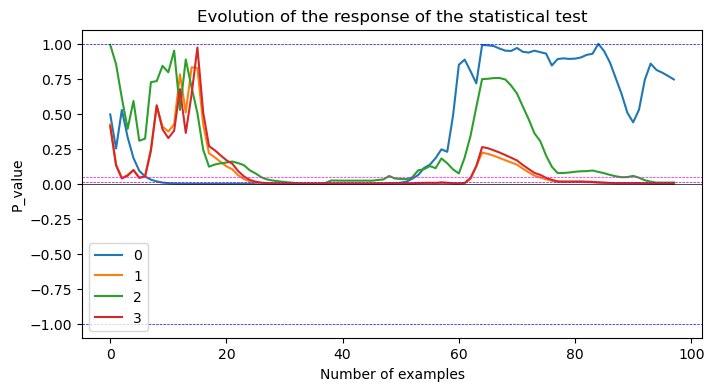

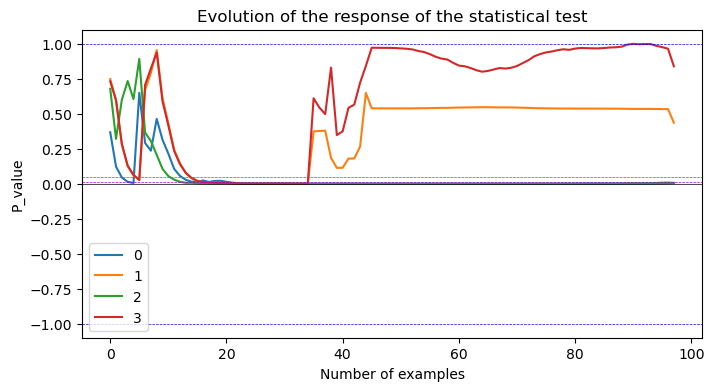

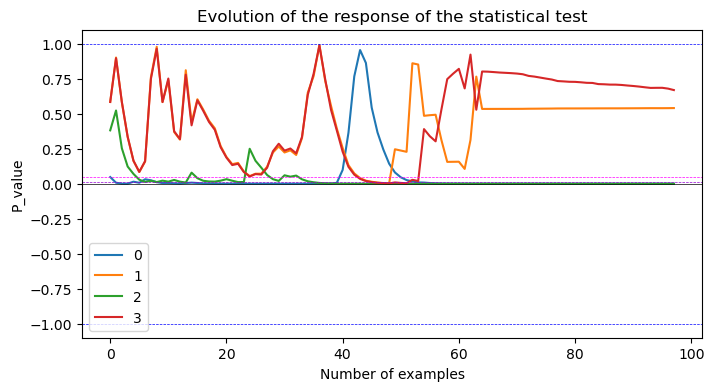

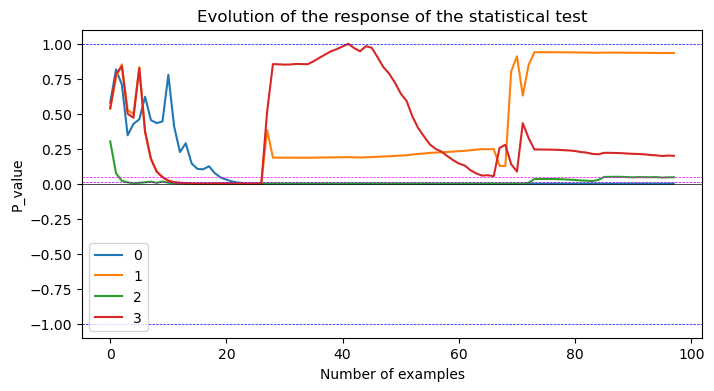

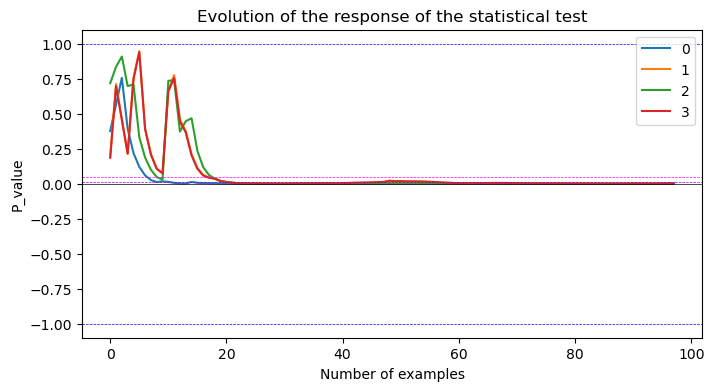

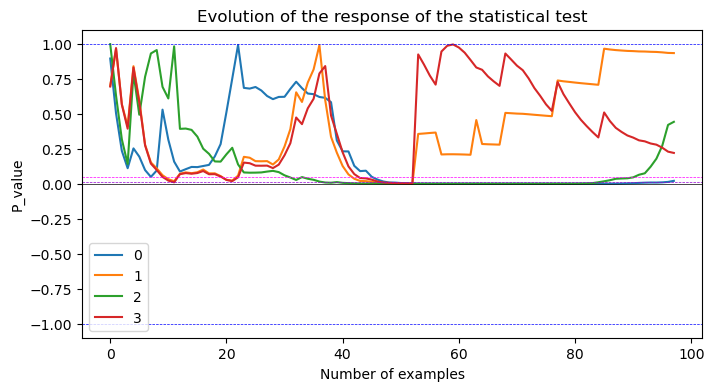

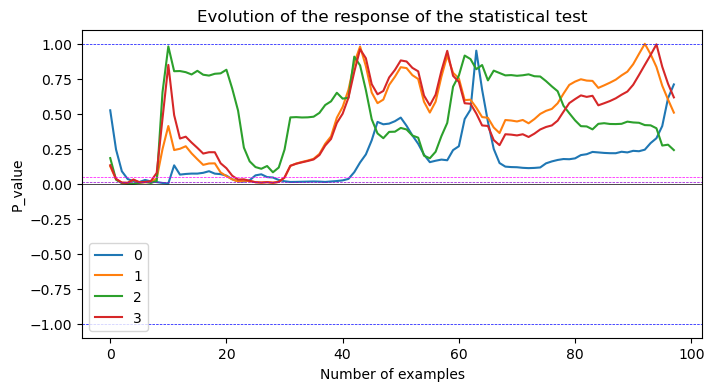

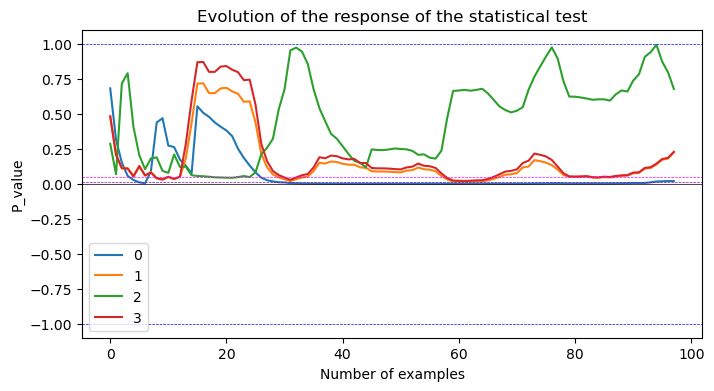

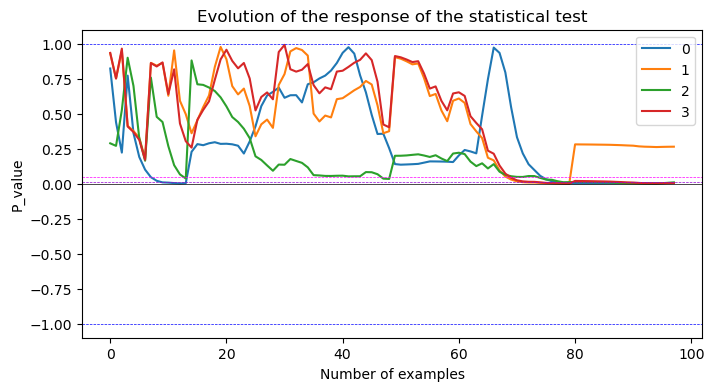

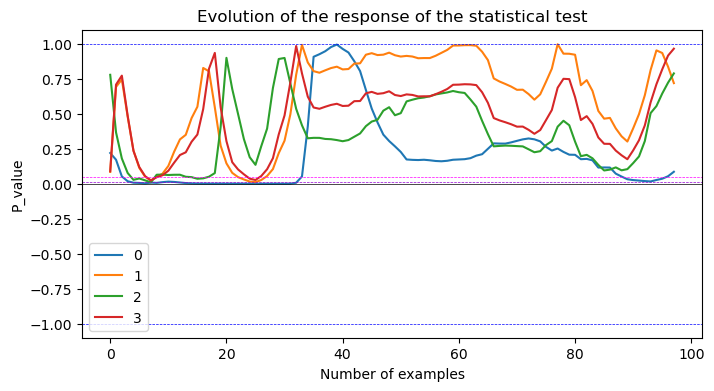

In [20]:
def detect_ood(nb_ep = 100,state_size = 4,action_size = 1,memory_size = 10):
    input_size = memory_size*(state_size+action_size)

    env = instanciate_cartpole(default_values)
    env = Memory(env, memory_size)
    observation = env.reset()

    pbar = trange(nb_ep)
    res = []
    err_preds = []
    pred_diffs = []
    
    terminated=False
    observation = env.reset()

    for t in pbar:
        
        #real_diffs = []
        #pred_diffs = []
        

        action = env.action_space.sample()
        previous_obs = observation
        observation, reward, terminated, info = env.step(action)
        history = env.get_history(True).reshape(input_size)

        real_diff = np.array(observation-previous_obs)
        pred_diff = pred_model.predict(history[None,:])[0]
        #real_diffs.append(real_diff)
        pred_diffs.append(pred_diff)
        err_pred = real_diff - pred_diff
        err_preds.append(err_pred)

        if terminated:
            observation = env.reset()
        """
        print(real_diff)
        print(pred_diff)
        print(err_pred)
        print()
        """
    pred_diffs = np.array(pred_diffs)
    err_preds = np.array(err_preds)
    #print(err_preds)
    evol_test(err_preds, path/'Plots')
    
    print(err_preds/pred_diffs)
    res.append(corrected_test(err_preds, pred_diffs))
    #res.append(z_test(err_preds))

    return np.array(res)

for i in range(10):
    detect_ood() #.mean(axis=0)

In [13]:
class NearestNeighborModel():
    def __init__(self, env, size_memory=5, confidence=True) -> None:
        self.size_memory = size_memory
        
        self.obs_limits = get_space_limits(env.observation_space)  
        self.act_limits = get_space_limits(env.action_space)
        
        self.state_size = self.obs_limits[0].shape[0]
        self.action_size = self.act_limits[0].shape[0]
        
        input_size, output_size = size_memory*(self.state_size + self.action_size), self.state_size
        
        #self.pred_model = MLP(input_size, output_size, size_hidden_layers, bias=True, final_activation=None, dropout=dropout)
        self.pred_model = 
        self.confidence = confidence
        if self.confidence:
            # nn.LeakyReLU has the advantage to have a symetrical derivative in any point excpet 0.
            # using for example the Softplus function would bias the variance estimation, and be problematic with the test
            self.conf_model = MLP(input_size, output_size, size_hidden_layers=[500, 100], bias=True, final_activation=nn.LeakyReLU(-1.0), dropout=dropout)

        #self.history_size = history_size
        self.criterion = nn.MSELoss()

    def predict_diff_states(self, history):
        X = torch.tensor(history).reshape(self.size_memory*(self.state_size+self.action_size)).float()  

        X.requires_grad = True
        pred_diff = self.pred_model(X) #.detach() 
        
        if self.confidence:
            std = self.conf_model(X) #.detach()
        else:
            std = torch.ones(pred_diff.shape).to(device)
        
        return pred_diff[0], std[0]

    def save(self, folder):
        os.makedirs(folder, exist_ok=True)
        torch.save(self.pred_model.cpu(), folder / 'pred_model.pth')
        if self.confidence:
            torch.save(self.conf_model.cpu(), folder / 'conf_model.pth')
        #joblib.dump(self.scaler_X, folder / 'scaler_X.bin', compress=True)
        #joblib.dump(self.scaler_Y, folder / 'scaler_Y.bin', compress=True)

    def load(self, folder):
        self.pred_model = torch.load(folder / 'pred_model.pth').to(device)
        if self.confidence:
            self.conf_model = torch.load(folder / 'conf_model.pth').to(device)
        #self.scaler_X = joblib.load(folder / 'scaler_X.bin')
        #self.scaler_Y = joblib.load(folder / 'scaler_Y.bin')


    def fit(self, env, nb_steps = 1000, num_epochs=25, lr :float =0.1):
        
        env = Memory(env, self.size_memory)
        models = {'pred':self.pred_model}
        if self.confidence:
            models['conf'] = self.conf_model
  
        for model_type, model in models.items():
            print('Fitting '+model_type+' : ' + str(model))
            model.train()

            # Observe that all parameters are being optimized
            optimizer = torch.optim.Adam(model.parameters(), lr)

            # Decay LR by a factor of 0.1 every 7 epochs
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

            writer = SummaryWriter('tensorboard/model_learning_'+model_type)
            since = time.time()

            best_loss = 1e10

            pbar = trange(num_epochs)
            for epoch in pbar:
                #print(f'Epoch {epoch}/{num_epochs - 1}')
                #print('-' * 10)

                # Each epoch has a training and validation phase
                phase_loss = {}
                    
                observation = env.reset()
                running_loss = 0.0
                
                for t in range(nb_steps):
                    #action, _state = agent.predict(observation)
                    action = env.action_space.sample()
                    previous_obs = observation
                    observation, reward, terminated, info = env.step(action)
                    history = env.get_history(True)
                    
                    observation = torch.FloatTensor(observation).reshape(self.state_size)     
                    #history = torch.FloatTensor(history).reshape(self.size_memory*self.state_size)     
                    #env.render()

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(True):
                        #print('inputs: ', inputs.shape)
                        #gap = (observation - previous_obs - pred_diff)/std
                        pred_diff, std = self.predict_diff_states(history)

                        if model_type == 'conf':
                            #print(observation, previous_obs, pred_diff)
                            loss = self.criterion(torch.abs(observation - previous_obs - pred_diff.detach()), std)
                            #loss = self.criterion((outputs - labels)**2, vari)
                        else:
                            loss = self.criterion((observation - previous_obs - pred_diff), torch.zeros(1)) #/std.detach()

                        loss.backward()
                        optimizer.step()

                        # statistics
                        running_loss += loss.item()
                        
                    if terminated:
                        observation = env.reset()
                        
                    
                scheduler.step()

                epoch_loss = running_loss / nb_steps
                    #print(f'{phase} Loss: {epoch_loss:.4f}')
                    #print()

                    # deep copy the model
                if epoch_loss < best_loss:
                    best_loss = epoch_loss

                writer.add_scalar(model_type+' Loss', epoch_loss, epoch)
                writer.flush()
                
                pbar.set_description("Loss: %2.4f" % (epoch_loss))

            time_elapsed = time.time() - since
            print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
            print(f'Best val Loss: {best_loss:4f}')

            
            model.eval()
            
        return best_loss

    def visualize(self, env, steps=100, saving_path=Path.cwd() / 'Plots', plot=True, render=False, figsize=(10, 4), dpi=300):
        env = Memory(env, self.size_memory)
        os.makedirs(saving_path, exist_ok=True)
        writer = SummaryWriter('tensorboard/visualize_model')
        
        self.pred_model = self.pred_model.to(device).eval()
        if self.confidence:
            self.conf_model = self.conf_model.to(device).eval()
        
        observations = []
        actions = []
        pred_diffs = []
        real_diffs = []
        pred_stds = []

        done=True

        if plot:
            pbar = trange(steps)
        else:
            pbar = range(steps)

        observation = torch.FloatTensor(env.reset()).reshape(self.state_size)     
        running_loss = 0.0

        for t in pbar:
            #action, _state = agent.predict(observation)
            action = env.action_space.sample()
            previous_obs = observation
            observation, reward, terminated, info = env.step(action)
            
            history = env.get_history(True)
            
            observation = torch.FloatTensor(observation).reshape(self.state_size)  
            if render:
                env.render()


            #print('inputs: ', inputs.shape)
            #gap = (observation - previous_obs - pred_diff)/std
            pred_diff, std = self.predict_diff_states(history)
            #pred_diff, std = self.predict_diff_states(previous_obs, action)
            pred_diff, std = pred_diff.detach(), std.detach()


            loss_conf = self.criterion(torch.abs(observation - previous_obs - pred_diff), std)

            loss_pred = self.criterion((observation - previous_obs - pred_diff)/std, torch.zeros(1))

            # statistics
            #running_loss += loss.item()

            if terminated:
                observation = env.reset()

            if plot:
                pbar.set_description("loss_pred: %2.4f, loss_conf: %2.4f" % (loss_pred, loss_conf))



            #print(f'{phase} Loss: {epoch_loss:.4f}')
            #print()
            #writer.add_scalars('run_14h', {'xsinx':np.sin(t), 'xcosx':np.cos(t), 'tanx': np.tan(t)}, t)
            for state_id in range(self.state_size):
                writer.add_scalar('observation/'+str(state_id), np.array(observation)[state_id], t)
                d =  {'predicted': np.array(pred_diff)[state_id], 'real': (np.array(observation) - np.array(previous_obs))[state_id]}

                writer.add_scalars('observation_difference/'+str(state_id),d, t)
                
                writer.add_scalar('observation_std/'+str(state_id), np.array(std)[state_id], t)

            for action_id in range(self.action_size):
                writer.add_scalar('action/'+str(action_id), np.array(action).reshape(self.action_size)[action_id], t)
                
            writer.flush()
            
            observations.append(np.array(observation)) #.numpy()
            actions.append(np.array(action).reshape(self.action_size))
            pred_diffs.append(np.array(pred_diff))
            real_diffs.append(np.array(observation) - np.array(previous_obs))
            pred_stds.append(np.array(std))

            """writer.add_scalar('state/'+str(state_id), distance.numpy(), i)
            writer.add_scalar('state/speed', speed.numpy(), i)
            writer.add_scalar('action', action.numpy(), i)
            writer.add_scalar('diff_distances/prediction', pred_diff_distance.numpy(), i)
            writer.add_scalar('diff_distances/reality', pred_diff_distance.numpy(), i)
            writer.add_scalar('diff_distances/variance', var_distance.numpy(), i)

            writer.add_scalar('diff_speed/prediction', pred_diff_speed.numpy(), i)
            writer.add_scalar('diff_speed/reality', real_diff_speed.numpy(), i)
            writer.add_scalar('diff_speed/variance', var_speed.numpy(), i)
            writer.flush()"""
            
        observations = np.array(observations)
        actions = np.array(actions)
        pred_diffs = np.array(pred_diffs)
        real_diffs = np.array(real_diffs)
        pred_stds = np.array(pred_stds)
        
        for state_id in range(self.state_size):
            

            evolution = {}
            evolution['prediction'] = np.array(pred_diffs[:,state_id])
            evolution['reality'] = np.array(real_diffs[:,state_id])
            evolution_df = pd.DataFrame(data=evolution)
            if plot:
                fig = plt.figure(dpi=dpi, figsize=figsize) 
                evolution_df.plot(title='Evolution of the differences of observation component ' + str(state_id), ax = plt.gca())
                #plt.ylabel('Distance (m)')
                plt.xlabel('Steps')
                plt.savefig(saving_path / 'evol_diff_obs', bbox_inches='tight')
                plt.show()
                
        for state_id in range(self.state_size):
            

            evolution = {}
            evolution['prediction'] = np.array(pred_diffs[:,state_id]) + observations
            evolution['reality'] = np.array(real_diffs[:,state_id]) + observations
            evolution_df = pd.DataFrame(data=evolution)
            if plot:
                fig = plt.figure(dpi=dpi, figsize=figsize) 
                evolution_df.plot(title='Evolution of the differences of observation component ' + str(state_id), ax = plt.gca())
                #plt.ylabel('Distance (m)')
                plt.xlabel('Steps')
                plt.savefig(saving_path / 'evol_diff_obs', bbox_inches='tight')
                plt.show()

        for action_id in range(self.action_size):
            
            evolution = {}
            evolution['prediction'] = np.array(actions[:,action_id])
            evolution['reality'] = np.array(actions[:,action_id])
            evolution_df = pd.DataFrame(data=evolution)
            if plot:
                fig = plt.figure(dpi=dpi, figsize=figsize) 
                evolution_df.plot(title='Evolution of the differences of action component ' + str(action_id), ax = plt.gca())
                #plt.ylabel('Distance (m)')
                plt.xlabel('Steps')
                plt.savefig(saving_path / 'evol_act', bbox_inches='tight')
                plt.show()

        

        """
        error_diff_distances = diff_distance_dict['prediction'] - diff_distance_dict['reality']
        if plot:
            plot_error_variance(error_diff_distances, var_distances, saving_path, 'distance', figsize=figsize, unit='m')
            plot_error_corrected(error_diff_distances, var_distances, saving_path, 'distance', figsize=figsize, dpi=dpi)
            plot_error_confidence_from_variance(error_diff_distances, var_distances, saving_path, 'distance', figsize=figsize, dpi=dpi, unit='m')

        error_diff_speeds = diff_speed_dict['prediction'] - diff_speed_dict['reality']
        if plot:
            plot_error_variance(error_diff_speeds, var_speeds, saving_path, 'speed', figsize=figsize, unit='m/s')
            plot_error_corrected(error_diff_speeds, var_speeds, saving_path, 'speed', figsize=figsize, dpi=dpi)
            plot_error_confidence_from_variance(error_diff_speeds, var_speeds, saving_path, 'speed', figsize=figsize, dpi=dpi, unit='m/s')
        """
        return observations, actions, pred_diffs, real_diffs, pred_stds


SyntaxError: invalid syntax (3554275634.py, line 14)